In [1]:
import pandas as pd
import numpy as np
import os
import re
import random
import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
random.seed(3)  #To make the randomization reproducible
pd.options.mode.chained_assignment = None  #To turn off specific warnings

In [3]:
#Imporing input data
samp = pd.read_csv("Data/sample_submission.csv")  #The parcelid's for the testset
props=pd.read_csv("Data/properties_2016.csv",low_memory=False)
merged_data=pd.read_csv("Data/InputForMachineLearning.csv")

In [4]:
#Ignoring extra column while importing dataset
merged_data=merged_data.drop(merged_data.columns[0], axis=1)

In [5]:
#Continuing with only numerical variables as 'string' variables need more analysis
merged_data = merged_data.select_dtypes(exclude=[object])
props = props.select_dtypes(exclude=[object])

In [6]:
#Inserting '-1' in place of empty values
merged_data.fillna(-1,inplace=True)
props.fillna(-1,inplace=True)

In [7]:
#Creating training data
train_x = merged_data.drop(['parcelid','logerror'],axis=1,inplace=False)
train_y = merged_data['logerror']

In [8]:
#Renaming column name for easy understaning
samp=samp.rename(columns={'ParcelId':'parcelid'})

In [9]:
#Creating test data
test = samp.loc[:,['parcelid']].merge(props,how='left',left_on='parcelid',right_on='parcelid')
test_x = test.drop(['parcelid','parcelid'],axis=1,inplace=False)

In [10]:
test_x = test_x.drop(['airconditioningtypeid','architecturalstyletypeid','basementsqft','buildingclasstypeid','decktypeid','threequarterbathnbr','finishedfloor1squarefeet','finishedsquarefeet6','finishedsquarefeet13','finishedsquarefeet15','finishedsquarefeet50','fireplacecnt','garagecarcnt','garagetotalsqft','numberofstories','poolcnt','poolsizesum','pooltypeid10','pooltypeid2','pooltypeid7','regionidneighborhood','storytypeid','typeconstructiontypeid','yardbuildingsqft17','yardbuildingsqft26','taxdelinquencyyear'],axis=1,inplace=False)

In [11]:
parameters = {'n_estimators':[5,10,15],'n_jobs':[-1],'oob_score':[False]}  # this can be extended
model = RandomForestRegressor()
grid = GridSearchCV(model,param_grid=parameters,scoring='neg_mean_absolute_error',cv=3)  
grid.fit(train_x,train_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 15], 'n_jobs': [-1], 'oob_score': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

  param_n_estimators  mean_test_score  std_test_score
0                  5        -0.087400        0.000638
1                 10        -0.081320        0.000289
2                 15        -0.078687        0.000682


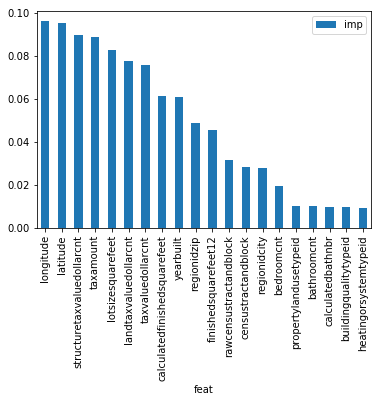

In [12]:
cv_results = pd.DataFrame(grid.cv_results_)
print(cv_results[["param_n_estimators","mean_test_score","std_test_score"]])
feat_imps = grid.best_estimator_.feature_importances_
fi = pd.DataFrame.from_dict({'feat':train_x.columns,'imp':feat_imps})
fi.set_index('feat',inplace=True,drop=True)
fi = fi.sort_values('imp',ascending=False)
fi.head(20).plot.bar()
#Save the plot in Output folder
plt.savefig("Output/ImportantFeatures.png")
plt.show()

In [13]:
test_y = grid.predict(test_x)
test_y = pd.DataFrame(test_y)
test_y[1] = test_y[0]
test_y[2] = test_y[0]
test_y[3] = test_y[0]
test_y[4] = test_y[0]
test_y[5] = test_y[0]  #For simplicity make identical predictions for all months
test_y.columns = ["201610","201611","201612","201710","201711","201712"]
submission = test_y.copy()
submission["parcelid"] = samp["parcelid"].copy()
cols = ["parcelid","201610","201611","201612","201710","201711","201712"]
submission = submission[cols]
filename = "LogErrorPrediction_" + re.sub("[^0-9]", "",str(datetime.datetime.now())) + '.csv'
print(filename)
#Save the .csv file in Output folder
submission.to_csv('Output/'+filename,index=False)

LogErrorPrediction_20180128195408248478.csv
